## Projeto: Transformada de Hilbert-Huang

---

#### Por [Beatriz Coimbra](https://github.com/beatrizmcoimbra) e [Fernanda Scovino](https://github.com/fernandascovino)

#### Resumo

Implementação da transformada de Hilbert-Huang para identificação de sons e expansão do [verbete na *Wikipédia*](https://pt.wikipedia.org/wiki/Transformada_de_Hilbert-Huang).

A transformada de Hilbert-Huang é uma técnica de decomposição de sinais em tempo-frequência em duas fases (EMD - Método de decomposição do modo empírico, e HSA - Análise espectral de Hilbert). Esta técnica foi desenvolvida num dos organismos da NASA por Northen E. Huang em 1998, e tem sido aplicada a sinais nos mais variados ramos da ciência, que vão desde a engenharia à medicina.<sup>1</sup>

O método de decomposição do modo empírico (EMD) nos permite decompor um conjunto de dados em um número
finito de componentes mais simples, chamados de funções do modo intrínseco (IMF).<sup>2</sup> Uma função de modo intrínseco é definida como qualquer função que tenha o mesmo, ou diferindo no máximo por um, números de zeros (cruzam o eixo x) e extremos, e também ter "envelopes simétricos" definidos pelos máximos e mínimos locais, respectivamente (os dados devem se localizar entre essas funções).<sup>3</sup>. As splines cúbicas são utilizadas para traçarmos esses envelopes, conectando os máximos/mínimos locais.<sup>4</sup>

#### Referências

1: [Hilbert-Huang transform - Wikipédia](https://en.wikipedia.org/wiki/Hilbert%E2%80%93Huang_transform)

2: [Tese *Utilização do método de decomposição empírico no processamento de dados de mobilidade urbana*, de Juliana Crespo (EMAp)](https://emap.fgv.br/dissertacao/utilizacao-metodo-de-decomposicao-empirico-processamento-de-dados-de-mobilidade-urbana)

3: [Hilbert-Huang transform - Scholarpedia](http://www.scholarpedia.org/article/Hilbert-Huang_transform)

4: [Spline - Wikipédia](https://pt.wikipedia.org/wiki/Spline)

5: [Cheney, W. & Kincaid, D. *Numerical Mathematics and Computing*](https://www.amazon.com/Numerical-Mathematics-Computing-Ward-Cheney/dp/1133103715/ref=dp_ob_title_bk)

6: [PyHHT Tutorials](https://pyhht.readthedocs.io/en/latest/tutorials.html)

7: [PyHHT Documentation](https://media.readthedocs.org/pdf/pyhht/latest/pyhht.pdf)

8: [Pitch Detection Method Based on Hilbert-Huang Transform for Erhu Music](http://umir.umac.mo/jspui/handle/123456789/14152)

### Criando os sons 

In [282]:
import numpy as np
import sounddevice as sd
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f', 'zeros']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


Vamos escolher inicialmente a duração das notas como 8000?? para podermos escutar o som. 

Posteriormente, para possibilitar os cálculos, vamos diminuir essa duração.

In [38]:
Fs = 8000
tempo = 8000

In [39]:
def cria_nota(f,Fs,tempo=Fs):
    
    """
    Cria o sinal correspondente à frequência escolhida (nota).
    
    :param f: frequência da nota
    :param Fs: frequência de amostragem
    :param tempo: duração da nota
    """
    
    x = np.arange(tempo)
    y = np.sin(2*np.pi*f*x/Fs)
    
    return y

In [40]:
freq_notas_dic = {
    'do': 261.6,
    'do#': 277,
    're': 293.5,
    're#': 311,
    'mi': 329.6,
    'fa': 349.2,
    'fa#': 370,
    'sol': 392,
    'sol#': 415.1,
    'la': 440,
    'la#': 466.2,
    'si': 493.8
}

In [41]:
def cria_musica(text, Fs, tempo):
    
    """
    Cria a música a partir de uma string de notas.
    
    :param text: string com as notas
    :param Fs: frequência de amostragem
    :param tempo: duração da nota
    """
    
    notas = text.split(',')
    musica = []
    
    for nota in notas:
        
        freq = cria_nota(freq_notas_dic[nota], Fs, tempo)
        musica = np.concatenate((musica, freq),axis=0)
            
    t = len(notas)*tempo
    return t, musica

In [42]:
t, teste = cria_musica('do,fa,mi,re,do,re,do,do,do,re,do,re,mi,fa', Fs, tempo)

In [43]:
sd.play(teste)

In [44]:
t

112000

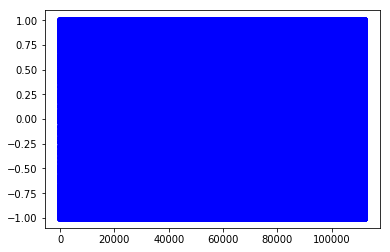

In [45]:
plt.plot(list(range(len(teste))), teste, 'bo')

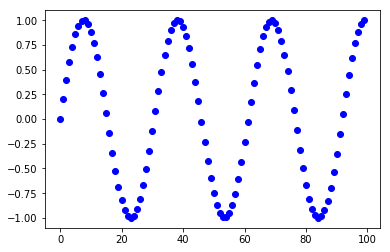

In [46]:
plt.plot(list(range(len(teste[:100]))), teste[:100], 'bo')

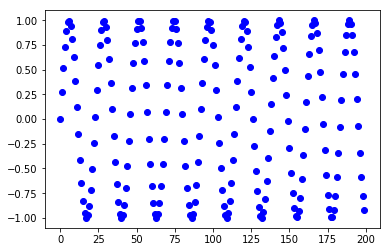

In [47]:
plt.plot(list(range(len(teste[8000:8200]))), teste[8000:8200], 'bo')

### Decompondo os sinais

In [103]:
from pyhht.visualization import plot_imfs
from pyhht.emd import EMD

In [111]:
tempo = 400
t, x = cria_musica('do,fa,mi,re,do,re,do,do,do,re,do,re,mi,fa', tempo, tempo)

In [106]:
t

5600

In [112]:
len(x)

5600

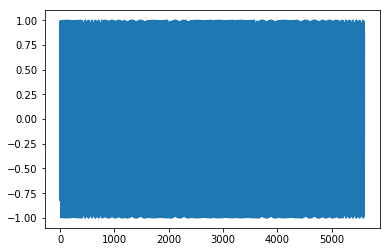

In [113]:
plt.plot(x)

#### 1. Identificando os mínimos e máximos do sinal $x(t)$

In [243]:
from scipy.signal import argrelextrema

In [271]:
def find_extremas(x):
    
    # Acha as posições da lista que correspondem aos mínimos e máximos locais
    max_t = argrelextrema(x, np.greater)[0]
    min_t = argrelextrema(x, np.less)[0]
    
    # Acha os valores de máximos e mínimos locais
    max_x = [x[i] for i in max_t]
    min_x = [x[i] for i in min_t]
    
    extremas = [(max_t, min_t), (max_x, min_x)]
    return extremas

In [272]:
x[:10]

array([ 0.        , -0.8235326 ,  0.93432894, -0.236499  , -0.66601187,
        0.9921147 , -0.45957986, -0.47070393,  0.99361131, -0.65658576])

In [273]:
extremos = find_extremas(x)

In [274]:
max_t, min_t = extremos[0]
max_x, min_x = extremos[1]

In [275]:
max_t, min_t

(array([   2,    5,    8, ..., 5576, 5584, 5592]),
 array([   1,    4,    7, ..., 5580, 5588, 5596]))

In [276]:
max_x[:10]

[0.934328942456612,
 0.9921147013144778,
 0.9936113105200085,
 0.9387338576538743,
 0.8305958991958131,
 0.6753328081210304,
 0.48175367410171616,
 0.6470559615694434,
 0.8090169943749426,
 0.9250772068344575]

In [277]:
min_x[:10]

[-0.8235325976284275,
 -0.6660118674342518,
 -0.4707039321653329,
 -0.6565857557529561,
 -0.8163392507171836,
 -0.9297764858882485,
 -0.9904614256966511,
 -0.994951016981301,
 -0.9429905358928649,
 -0.8375280400421464]

#### 2. Encontrando os envelope superior e inferior de $x(t)$ passando um spline cúbico através dos máximos e mínimos respectivamente

Utilizando o método [`scipy.interpolate.UnivariateSpline`](https://docs.scipy.org/doc/scipy-0.19.1/reference/generated/scipy.interpolate.UnivariateSpline.html) para a interpolação de spline cúbica:

In [156]:
from scipy.interpolate import UnivariateSpline

In [279]:
def find_envelopes(x, extremos):

    """
    Obtém os envelopes superior e inferior da função (por uma spline cúbica), e a média.
    
    :param x: pontos da função
    :param extremos: retorno da função find_extremas
    """
    
    max_t, min_t = extremos[0]
    max_x, min_x = extremos[1]
    
    # Obtém o envelope superior
    f_max = UnivariateSpline(max_t, max_x, k=3)
    s_max = f_max(max_t)
    
    # Obtém o envelope inferior
    f_min = UnivariateSpline(min_t, min_x, k=3)
    s_min = f_min(min_t)
    
    # Calcula a média dos envelopes
    t = list(range(len(x)))
    m_t = (f_max(t) + f_min(t))/2
    
    return s_max, s_min, m_t

In [280]:
s_max, s_min, m_t = find_envelopes(x, extremos)

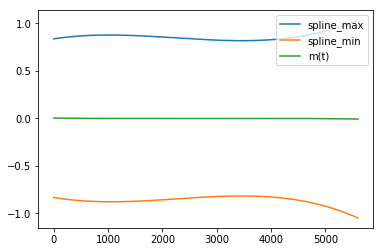

In [286]:
plt.plot(max_t, s_max, label='spline_max')
plt.plot(min_t, s_min, label='spline_min')
plt.plot(m_t, label='m(t)')
plt.legend()

#### 3. Calcule a média dos envelopes superior e inferior como $m(t)$

Calculamos no item anterior, mas aqui demos um zoom:

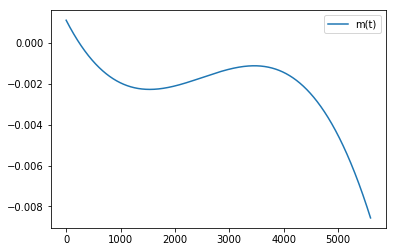

In [287]:
plt.plot(m_t, label='m(t)')
plt.legend()

#### 4. Obter um candidato do FMI usando a fórmula $h_{k}(t) = x(t) - m(t)$

In [288]:
h = x - m_t

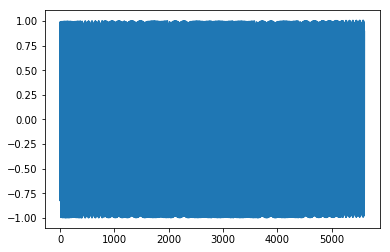

In [289]:
plt.plot(h_t)

In [290]:
h

array([-0.00110196, -0.8246294 ,  0.9332373 , ..., -0.47870684,
        0.29357097,  0.89379146])

#### 5. Verifique se as propriedades $h_{k}(t)$ é uma função do modo intrínseco (IMF)

> 1. Em todo o conjunto de dados, o número de extremos e números
 de raízes (zeros da função) devem ser iguais ou diferem por 1.
> 2. Em qualquer ponto, o valor médio do envelope definido pelo máximo local e o envelope definido pelo mínimo local é  zero.

In [325]:
def imf_test(h):
    
    """
    Verifica se a função segue as propriedades de uma IMF
    
    :param h: pontos da função
    """

    prop1 = False
    prop2 = False
    
    # Verifica a quantidade de vezes que h troca o sinal
    h_zeros = 0
    for i in range(len(h)-1):
        
        if np.sign(h[i]) != np.sign(h[i+1]):
            h_zeros += 1
            
    # Acha os extremos
    extremos = find_extremas(h)
    h_extremos = len(extremos[0][0]) + len(extremos[0][1])
    
    # Verifica propriedade 1
    print("# de zeros: " + str(h_zeros))
    print("# de extremos: " + str(h_extremos))
    
    if abs(h_zeros - h_extremos) <= 1:
        
        prop1 = True        
        
    # Verifica a propriedade 2
    s_max, s_min, m_t = find_envelopes(h, extremos)
    
    m_zeros = sum([1 for i in m_t if i == 0])
    
    print("\n# de zeros: " + str(m_zeros))
    print('# de pontos: ' + str(len(m_t)))
    
    if len(m_t) == m_zeros:
        
        prop2 = True
    
    # Retorna o resultado
    if prop1 and prop2:
        return True
    else:
        return False

In [326]:
imf_test(h)

# de zeros: 3011
# de extremos: 3011

# de zeros: 276
# de pontos: 5600


False

#### 6. Repetir o processo utilizando o resíduo, $r_1 = x(t) - h_1$.

In [327]:
r = x - h

In [328]:
r

array([ 0.00110196,  0.0010968 ,  0.00109164, ..., -0.00854328,
       -0.00855171, -0.00856014])

In [329]:
imf_test(r)

# de zeros: 1
# de extremos: 2


error: (m>k) failed for hidden m: fpcurf0:m=1

----

### Utopia

In [225]:
decomposer = EMD(x)
imfs = decomposer.decompose()

Mode 3, Iteration 600
0 minima > 0; 204 maxima < 0.
Mode 5, Iteration 800
0 minima > 0; 99 maxima < 0.
Mode 7, Iteration 1000
1 minima > 0; 31 maxima < 0.
Mode 7, Iteration 1200
0 minima > 0; 33 maxima < 0.
Mode 7, Iteration 1400
0 minima > 0; 32 maxima < 0.


2
3
4
5
6
7
8
9
10
11


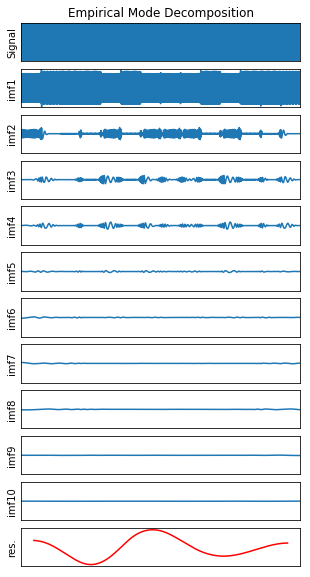

In [242]:
from pylab import rcParams
rcParams['figure.figsize'] = 5, 10

plot_imfs(teste, imfs)

### Rascunho

In [95]:
t = np.linspace(0, 1, 1000)
modes = np.sin(2 * pi * f * t /8000) + np.sin(2 * pi * 440 * t /8000)

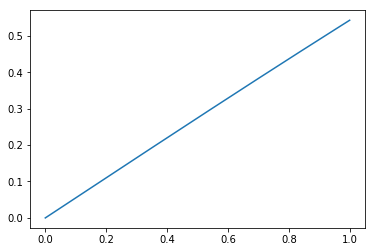

In [99]:
plt.plot(t, modes)

In [97]:
sd.play(modes)

In [84]:
tempo = 100
Fs = 100
f = 261.6

x = np.arange(tempo)
y = np.sin(2 * np.pi * f * x/Fs)

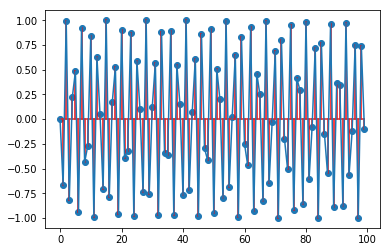

In [101]:
plt.stem(x, y, 'r', )
plt.plot(x, y)